This IPL prediction is a classification as well regression problem. Let's go step by step in analysing the data and predicting which team will win or lose along with the stats and comparisons.

Let's get started...!

# Step by step approach
1. Problem Definition
2. Data analysis or EDA
3. Evaluation
4. Features
5. Modelling
6. Experimentation

# 1. Problem Definition

Here we have with us the data of IPL from season 2008-2017. 
We aim to answer 2 key questions:

* What is the best classification algorithm to predict the results of two teams accurately, demonstrating the most important features within it?
* What is the best regression algorithm to predict a bowler’s runs conceded?

# 2. Data 

We have got the data from Kaggle. It uses two sets of data based from 2008 -2017; match-by-match and ball by ball statistics. The datasets are suitable to extract some key data, provide some statistical descriptive and visualizations and apply some machine learning techniques using Python.
https://www.kaggle.com/aadilmalik94/ipl-cricket-dataset

# 3. Evaluation

The evaluation metric for the calssification problem would be the accuracy. We will try to achieve 90% above accuracy for our model.

The evaluation metric for regression problem would be RMSE.

# 4. Features

We have got some features within our data such as the Man of the Match, toss winner, venue(home  ground or not), any many more. Let us loo at each feature and evaluate which is the most important feature.

## Tools preparation



In [1]:
#import all necessary EDA and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import models from scikit learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#import evaluation metric
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [2]:
df_matches = pd.read_csv("Data/datasets_108877_259936_matches.csv")
df_deliveries = pd.read_csv("Data/deliveries.csv")
#df_matches.head(), df_deliveries.head()

In [3]:
#let's check for missing values if any
df_matches.isna().sum()

id                   0
season               0
city                 7
date                 0
team1                0
team2                0
toss_winner          0
toss_decision        0
result               0
dl_applied           0
winner               3
win_by_runs          0
win_by_wickets       0
player_of_match      3
venue                0
umpire1              1
umpire2              1
umpire3            636
dtype: int64

In [4]:
df_deliveries.isna().sum()

match_id                 0
inning                   0
batting_team             0
bowling_team             0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
is_super_over            0
wide_runs                0
bye_runs                 0
legbye_runs              0
noball_runs              0
penalty_runs             0
batsman_runs             0
extra_runs               0
total_runs               0
player_dismissed    143022
dismissal_kind      143022
fielder             145091
dtype: int64

Let us explore with some visualization on the data we have!!

In [5]:
#count of fours and sixes by each batsman 
fours = df_deliveries[df_deliveries["batsman_runs"] == 4]
sixes = df_deliveries[df_deliveries["batsman_runs"] == 6]

fours_batsman = fours.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count().reset_index()
sixes_batsman = sixes.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count().reset_index()

fours_batsman.rename(columns={"batsman_runs":"4s"}, inplace=True)
sixes_batsman.rename(columns={"batsman_runs":"6s"}, inplace=True)

del_batsman = df_deliveries.groupby(["match_id", "inning", "batsman"])
batsman = del_batsman["batsman_runs"].sum().reset_index()
batsman = batsman.merge(fours_batsman, left_on = ["match_id", "inning", "batsman"],
                        right_on = ["match_id","inning", "batsman"],
                        how="left")
batsman = batsman.merge(sixes_batsman, left_on = ["match_id", "inning", "batsman"],
                        right_on = ["match_id","inning", "batsman"],
                        how="left")
#let us add strike rate for each player inning wise
balls_faced = df_deliveries[df_deliveries["wide_runs"] == 0] #ignoring the wides
balls_faced = balls_faced.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count()
batsman = batsman.merge(balls_faced, left_on=["match_id", "inning", "batsman"],
                        right_on=["match_id", "inning", "batsman"],
                        how="left")
batsman.rename(columns={"batsman_runs_x":"runs"}, inplace=True)
batsman.rename(columns={"batsman_runs_y":"balls_faced"}, inplace=True)
batsman["strike_rate"] = (batsman["runs"] / batsman["balls_faced"] * 100).round(2)

#now we will add the season runs for each player
batsman = df_matches[["id","season"]].merge(batsman, left_on=["id"],
                                          right_on=["match_id"],
                                          how="left")
batsman.drop("match_id", axis=1, inplace=True)
season_runs = batsman.groupby(["season","batsman"])["runs"].sum()

#top 15 run getters in a single edition
top_edition = season_runs.sort_values(ascending=False)
top_10_edition = top_edition[:10]
#top_10 run getters in IPL history
top_IPL = batsman.groupby(["batsman"])["runs"].sum().sort_values(ascending=False)
top_10_IPL = top_IPL[:10]

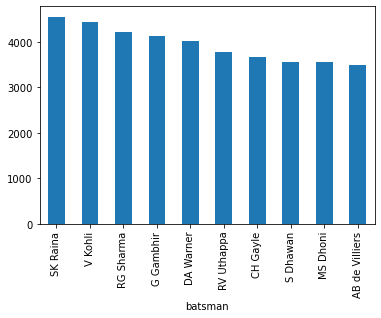

In [6]:
#Plotting Top 10 run getters in IPL history
top_10_IPL.plot(x='batsman', y="runs", kind="bar");

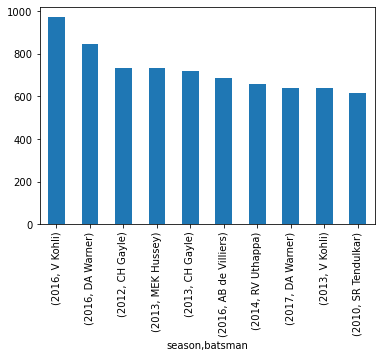

In [7]:
#Plotting Top 10 single edition individual total scores
top_10_edition.plot(x="batsman", y="runs", kind="bar");

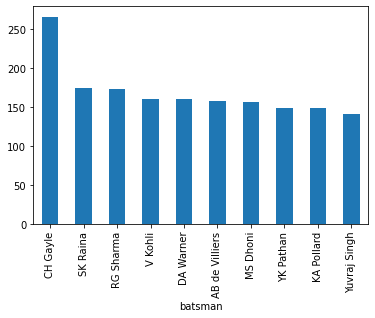

In [8]:
#Let's plot the most sixes in IPL overall history
most_sixes = batsman.groupby(["batsman"])["6s"].sum().sort_values(ascending=False)
most_sixes = most_sixes[:10]
most_sixes.plot(x="batsman", y="No of Sixes", kind="bar");


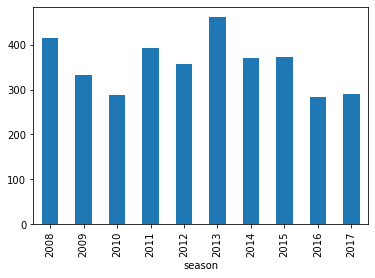

In [9]:
# Now let me plot the season wise scores of my favourite player
my_fav_player = batsman[batsman["batsman"] == "MS Dhoni"].groupby(["season"])["runs"].sum()
my_fav_player.plot(x="season", y="runs", kind="bar")

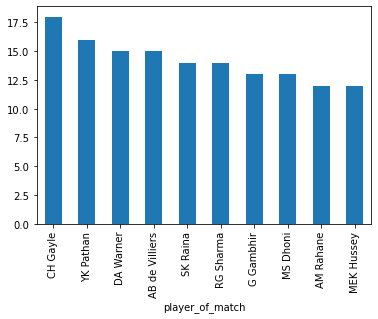

In [10]:
#let us now plot the most Man of the Match awards in IPL
mom_awards = df_matches.groupby(["player_of_match"])["player_of_match"].count().sort_values(ascending=False)
mom_awards_10 = mom_awards[:10]
mom_awards_10.plot(kind="bar");

So far we had been looking the statistics of a batsman (most runs scored, most sixes, most mom awards....)

Now let us see some statistics of a bowler.

In [24]:
#A wicket is credited to a bowler only if the dismissal type fall in the following
bowler_wickets = ["bowled", "caught", "caught and bowled", "hit wicket", "lbw", "stumped"]

#byes, leg-byes doesn't add up to bowlers runs given
#byes, leg-byes and wides add up to the extras given by the bowling team
bowler = pd.DataFrame()
bowler["tot_runs"] = df_deliveries.groupby(["bowler"])["total_runs"].sum()
bowler_extras = df_deliveries.groupby(["bowler"])[["wide_runs","bye_runs","legbye_runs"]].sum()
bowler["extras"] = bowler_extras.sum(axis=1)
bowler["runs_conceeded"] = bowler["tot_runs"] - bowler["extras"]
bowler["overs"] = df_deliveries.groupby(["bowler"])["over"].count().div(6).round(1)
bowler["economy"] = (bowler["runs_conceeded"] / bowler["overs"]).round(2)
dismissals = df_deliveries[df_deliveries["dismissal_kind"].isin(bowler_wickets)]
dismissals = dismissals.groupby(["bowler"])["dismissal_kind"].count().reset_index()
bowler = dismissals.merge(bowler, left_on = ["bowler"], right_on = ["bowler"], how="left")
bowler.rename(columns={"dismissal_kind":"wickets"}, inplace=True)
bowler.head()

,bowler,wickets,tot_runs,extras,runs_conceeded,overs,economy
0,A Ashish Reddy,18,400,12,388,45.0,8.62
1,A Chandila,11,245,3,242,39.0,6.21
2,A Choudhary,5,144,6,138,18.0,7.67
3,A Flintoff,2,106,1,105,11.0,9.55
4,A Kumble,45,1089,57,1032,163.8,6.30


In [35]:
# top wicket taker in IPL
top_wicket_10 = bowler.groupby(["bowler"])["wickets"].sum().sort_values(ascending=False)[:10]
top_wicket_10

bowler
SL Malinga         154
A Mishra           134
Harbhajan Singh    127
PP Chawla          126
DJ Bravo           122
B Kumar            111
A Nehra            106
R Vinay Kumar      103
Z Khan             102
R Ashwin           100
Name: wickets, dtype: int64

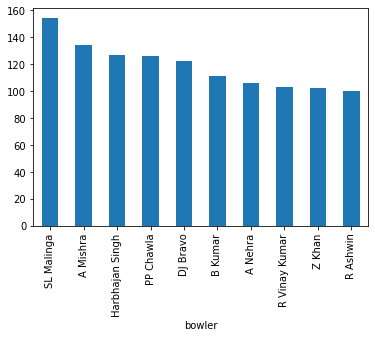

In [37]:
#plot the leading wicket taker in IPL history
top_wicket_10.plot(kind="bar");

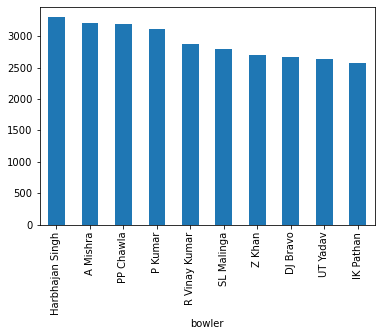

In [41]:
#most runs conceeded
most_run_given = bowler.groupby(["bowler"])["runs_conceeded"].sum().sort_values(ascending=False)[:10]
most_run_given.plot(kind="bar");

In [59]:
#least economy with atleast min 100 matches played
matches = df_deliveries.groupby(["bowler"])["match_id"].nunique().reset_index()
bowler = matches.merge(bowler, left_on = ["bowler"], right_on = ["bowler"], how="left")
bowler.rename(columns={"match_id":"matches"},inplace=True)

In [60]:
bowler.head()

,bowler,matches,wickets,tot_runs,extras,runs_conceeded,overs,economy
0,A Ashish Reddy,20,18.0,400.0,12.0,388.0,45.0,8.62
1,A Chandila,12,11.0,245.0,3.0,242.0,39.0,6.21
2,A Choudhary,5,5.0,144.0,6.0,138.0,18.0,7.67
3,A Flintoff,3,2.0,106.0,1.0,105.0,11.0,9.55
4,A Kumble,42,45.0,1089.0,57.0,1032.0,163.8,6.30


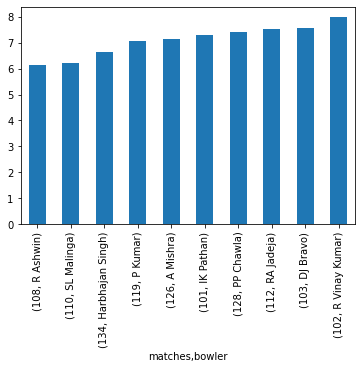

In [77]:
least_economy = bowler[bowler["matches"] > 100]
least_economy = least_economy.groupby(["matches","bowler"])["economy"].sum().sort_values(ascending=True)
least_economy.plot(kind="bar");

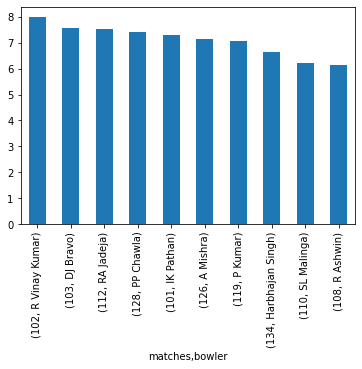

In [79]:
#most expensive bowler with min 100 matches
high_economy = bowler[bowler["matches"] > 100]
high_economy = high_economy.groupby(["matches","bowler"])["economy"].sum().sort_values(ascending=False)
high_economy.plot(kind="bar");

We have looked at some statistical data of both bowlers and batsman.

We will now fill the missing values and convert our data to numerical values and proceed in building our model.

In [80]:
df_matches.isna().sum()

id                   0
season               0
city                 7
date                 0
team1                0
team2                0
toss_winner          0
toss_decision        0
result               0
dl_applied           0
winner               3
win_by_runs          0
win_by_wickets       0
player_of_match      3
venue                0
umpire1              1
umpire2              1
umpire3            636
dtype: int64

In [81]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               636 non-null    int64  
 1   season           636 non-null    int64  
 2   city             629 non-null    object 
 3   date             636 non-null    object 
 4   team1            636 non-null    object 
 5   team2            636 non-null    object 
 6   toss_winner      636 non-null    object 
 7   toss_decision    636 non-null    object 
 8   result           636 non-null    object 
 9   dl_applied       636 non-null    int64  
 10  winner           633 non-null    object 
 11  win_by_runs      636 non-null    int64  
 12  win_by_wickets   636 non-null    int64  
 13  player_of_match  633 non-null    object 
 14  venue            636 non-null    object 
 15  umpire1          635 non-null    object 
 16  umpire2          635 non-null    object 
 17  umpire3         

We will fill the missing values with the median of the data as we as we will drop the umpire3 column as it has more missing values.
We will also convert the strings to numbers.

In [85]:
for label, content in df_matches.items():
    if pd.api.types.is_string_dtype(content):
        df_matches[label] = content.astype("category").cat.as_ordered()
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   id               636 non-null    int64   
 1   season           636 non-null    int64   
 2   city             629 non-null    category
 3   date             636 non-null    category
 4   team1            636 non-null    category
 5   team2            636 non-null    category
 6   toss_winner      636 non-null    category
 7   toss_decision    636 non-null    category
 8   result           636 non-null    category
 9   dl_applied       636 non-null    int64   
 10  winner           633 non-null    category
 11  win_by_runs      636 non-null    int64   
 12  win_by_wickets   636 non-null    int64   
 13  player_of_match  633 non-null    category
 14  venue            636 non-null    category
 15  umpire1          635 non-null    category
 16  umpire2          635 non-null    category
 1

We have converted strings to categories(categories in pandas is one way of converting to numbers)

In [86]:
df_matches.drop(["umpire3","result"],axis=1,inplace=True)
df_matches.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN


In [89]:
#While filling the missing values we should fill the numerical data and categorical data sepeerately.
#Filling Numerical missing data
for label, content in df_matches.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

There's no missing numerical data

In [91]:
#Filling categorical missing data
for label, content in df_matches.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_matches[label] = pd.Categorical(content).codes + 1

df_matches.isna().sum()

id                 0
season             0
city               0
date               0
team1              0
team2              0
toss_winner        0
toss_decision      0
dl_applied         0
winner             0
win_by_runs        0
win_by_wickets     0
player_of_match    0
venue              0
umpire1            0
umpire2            0
dtype: int64

# 5. Modelling

In [93]:
#split data into X and y
X = df_matches.drop(["winner"], axis=1)
y = df_matches["winner"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


In [94]:
models = {"LogisticRegression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "RandomForestClassifier": RandomForestClassifier()
}

#Let's create a function to fit the model and score
def fit_score(models,X_train, X_test, y_train, y_test):
    """
    Fits the model with X_train and y_train and evaluates the model with X_test and y_test datasets.
    """
    scores = {}
    np.random.seed(42)
    for label, model in models.items():
        model.fit(X_train, y_train)
        scores[label] = model.score(X_test, y_test)
    return scores

In [96]:
model_scores = fit_score(models,X_train,X_test,y_train,y_test)
model_scores

C:\Users\gselvara\Documents\ipl-project\env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'LogisticRegression': 0.2734375,
 'KNN': 0.1953125,
 'RandomForestClassifier': 0.71875}

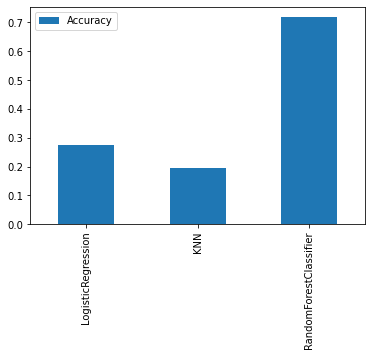

In [103]:
#comparison of the model's performance
model_compare = pd.DataFrame(model_scores, index=["Accuracy"])
model_compare.T.plot.bar();

Let us improve the model's performance by tuning the hyperparameters!!

In [104]:
#Hyperparameter tuning using RandomizedSearchCV
np.random.seed(42)
ran_search_grid = {"n_estimators": np.arange(10,1000,50),
                   "max_depth":[None,3,5,10],
                   "min_samples_split": np.arange(2,20,2),
                   "min_samples_leaf": np.arange(1,20,2)} 
ran_search_cv = RandomizedSearchCV(RandomForestClassifier(),
                                   param_distributions=ran_search_grid,
                                   cv=5,
                                   n_iter=20,
                                   verbose=1)
ran_search_cv.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\gselvara\Documents\ipl-project\env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.8min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=1)

In [106]:
ran_search_cv.best_params_

{'n_estimators': 510,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_depth': None}

In [107]:
ran_search_cv.score(X_test, y_test)

0.6953125

We could see that our model upon optimizing its hyperparameters via RandomizedSearchCV didnt perform well compared to the base version of our model.

Let us check if GridSearchCV could help us improve the accuracy!

In [108]:
#Hyperparameter tuning using GridSearchCV
# grid_search_cv = GridSearchCV(RandomForestClassifier(),
#                           param_grid=ran_search_grid,
#                           cv=5,
#                           verbose=True)
# grid_search_cv.fit(X_train, y_train)

Fitting 5 folds for each of 7200 candidates, totalling 36000 fits


C:\Users\gselvara\Documents\ipl-project\env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 36000 out of 36000 | elapsed: 657.5min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 3, 5, 10],
                         'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                         'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
             verbose=True)

I have commented the above piece of code as it nearly took me 10hours of time to complete, which is highly not recommended. Choose the hyperparameters wisely and reduce the models run time. This was run just to check the finest hyperparameters to increase the performance of the modelin terms of Accuracy for the Classification problem.

In [109]:
grid_search_cv.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 360}

The best hyperpameters for the RandomForestClassifier is,

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 360}

In [110]:
grid_search_cv.score(X_test,y_test)

0.765625

We have increased the accuracy from 71% to 76.5% by tuning the hyperparameters.

You could also try out some other models to see which best fits our data. I am stoping the experimentation here and will evaluate the model with certain evaluation metrics.

In [112]:
y_preds = grid_search_cv.predict(X_test)
y_preds

array([ 7, 14, 10,  7,  1,  3,  8,  1, 13,  8, 14,  2,  7,  8,  1,  4, 13,
        7,  5,  7,  8, 14,  8,  1,  8,  5,  3,  7,  3,  7,  5,  7,  8,  3,
       10,  3,  8,  2,  1,  8,  1,  5,  1, 13, 11, 10,  1,  8,  1,  3,  3,
        1,  3,  5,  1,  3,  7,  3,  5,  5, 10,  1,  1,  7, 14, 10,  8, 11,
        8,  3,  7,  3, 14,  1,  1, 11,  7,  2,  1, 14, 10,  7,  1,  8, 10,
        5,  1, 13, 10, 13,  7, 10, 13, 10,  1,  1, 13,  4,  5, 14,  2, 14,
        1, 13,  8,  3,  1, 14,  2,  8,  8, 10,  8, 13,  5, 13,  7,  7,  5,
       13,  1,  3, 10,  7,  3,  8,  1, 13], dtype=int8)

In [114]:
#confusion matrix
print(confusion_matrix(y_test, y_preds))

[[ 0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0 22  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  2  0  0  1  0  0  0  0  0]
 [ 0  0  1  1  0  9  0  1  0  0  1  0  0]
 [ 0  0  1  0  0  0 15  0  0  0  0  1  0]
 [ 0  1  0  1  0  1  0 11  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  1  0 10  0  1  0]
 [ 0  0  0  0  0  0  0  1  0  0  2  0  0]
 [ 0  1  0  1  0  1  1  1  0  0  0  9  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  6]]


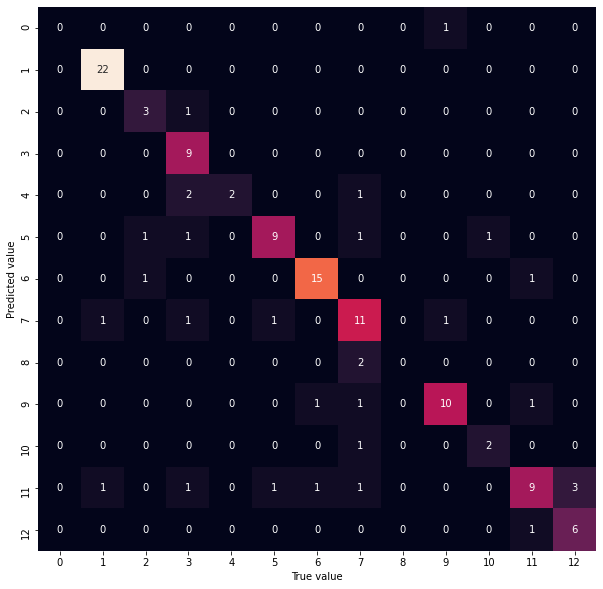

In [118]:
#plotting confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(confusion_matrix(y_test,y_preds),
                 annot=True,
                 cbar=False)
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.plot();

In [119]:
#Classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.92      1.00      0.96        22
           2       0.60      0.75      0.67         4
           3       0.60      1.00      0.75         9
           4       1.00      0.40      0.57         5
           5       0.82      0.69      0.75        13
           7       0.88      0.88      0.88        17
           8       0.61      0.73      0.67        15
           9       0.00      0.00      0.00         2
          10       0.83      0.77      0.80        13
          11       0.67      0.67      0.67         3
          13       0.75      0.53      0.62        17
          14       0.67      0.86      0.75         7

    accuracy                           0.77       128
   macro avg       0.64      0.64      0.62       128
weighted avg       0.77      0.77      0.75       128



C:\Users\gselvara\Documents\ipl-project\env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [131]:
clf.fit(X_test,y_test)
clf.feature_importances_

array([0.07074509, 0.04838723, 0.07057169, 0.07395062, 0.10399044,
       0.12364533, 0.09970189, 0.02416229, 0.00179518, 0.0522206 ,
       0.05367531, 0.08029177, 0.08470297, 0.05196275, 0.06019686])

In [146]:
#map feature importance array with its respective column names
feat_imp = dict(zip((X.columns),list(clf.feature_importances_ * 100))) 
feat_imp

{'id': 7.074509231093495,
 'season': 4.838722585724171,
 'city': 7.057169341814593,
 'date': 7.3950619651283915,
 'team1': 10.399043777206371,
 'team2': 12.364533013723946,
 'toss_winner': 9.970188615416683,
 'toss_decision': 2.4162285016681695,
 'dl_applied': 0.17951800631938564,
 'win_by_runs': 5.222060153817854,
 'win_by_wickets': 5.3675311570517446,
 'player_of_match': 8.029176530743642,
 'venue': 8.470296573859383,
 'umpire1': 5.196274777639531,
 'umpire2': 6.01968576879264}

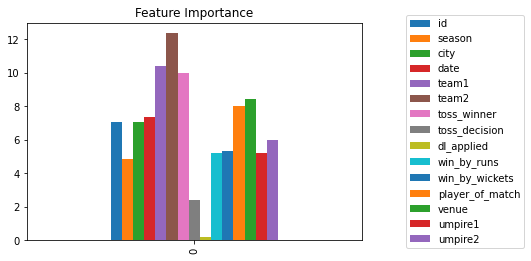

In [178]:
feature_imp = pd.DataFrame(feat_imp,index=[0])#, columns=[X.columns])
feature_imp.plot(kind="bar", title ="Feature Importance")
plt.legend(loc="right",bbox_to_anchor=(1.5, 0.5));
# fig, ax = plt.subplots(figsize=(10,10))
# ax.plot(feature_imp)#, labels=X.columns)
# ax.legend(loc="upper center")
# plt.title("Feature Importance")
# plt.xlabel("Features")
# plt.ylabel("Value")
# plt.plot()
# feature_imp

# 6. Experimentation
If you havent hit your evaluation metric yet, ask yourself..

could you collect more data?
could you try a better model? Like CatBoost or XGBoost?
could you improve current models?

## Progressing into the next phase of this project, let's see how our Regression model works on predicting the runs leaked by the bowler in IPL.

In [179]:
bowler.head()

,bowler,matches,wickets,tot_runs,extras,runs_conceeded,overs,economy
0,A Ashish Reddy,20,18.0,400.0,12.0,388.0,45.0,8.62
1,A Chandila,12,11.0,245.0,3.0,242.0,39.0,6.21
2,A Choudhary,5,5.0,144.0,6.0,138.0,18.0,7.67
3,A Flintoff,3,2.0,106.0,1.0,105.0,11.0,9.55
4,A Kumble,42,45.0,1089.0,57.0,1032.0,163.8,6.30


In [180]:
bowler_coef = bowler.drop(["bowler", "tot_runs"], axis=1)
bowler_coef.head()

,matches,wickets,extras,runs_conceeded,overs,economy
0,20,18.0,12.0,388.0,45.0,8.62
1,12,11.0,3.0,242.0,39.0,6.21
2,5,5.0,6.0,138.0,18.0,7.67
3,3,2.0,1.0,105.0,11.0,9.55
4,42,45.0,57.0,1032.0,163.8,6.30


In [182]:
bowler_coef.corr()

,matches,wickets,extras,runs_conceeded,overs,economy
matches,1.000000,0.951086,0.893340,0.983408,0.982533,-0.198990
wickets,0.951086,1.000000,0.907776,0.973585,0.978780,-0.219055
extras,0.893340,0.907776,1.000000,0.919882,0.929335,-0.222318
runs_conceeded,0.983408,0.973585,0.919882,1.000000,0.995034,-0.180150
overs,0.982533,0.978780,0.929335,0.995034,1.000000,-0.216761
economy,-0.198990,-0.219055,-0.222318,-0.180150,-0.216761,1.000000


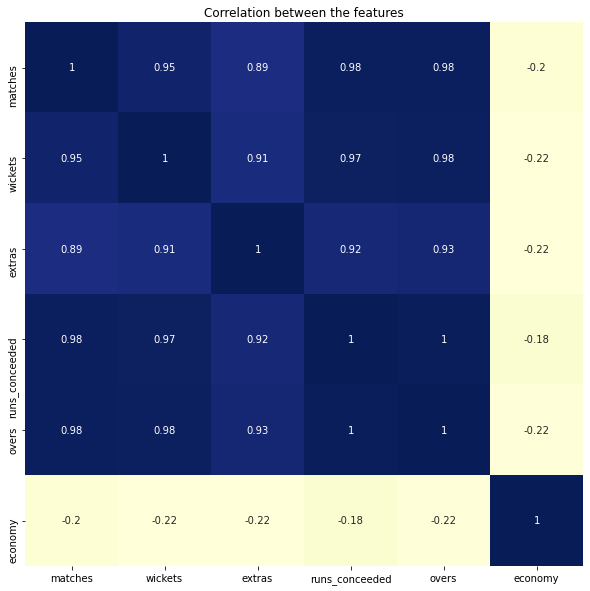

In [186]:
#plot the correlation matrix
fig, ax = plt.subplots(figsize=(10,10))
ax= sns.heatmap(bowler_coef.corr(), annot=True, cbar=False, cmap="YlGnBu")
plt.title("Correlation between the features");

In [187]:
bowler.isna().sum()

bowler             0
matches            0
wickets           46
tot_runs          46
extras            46
runs_conceeded    46
overs             46
economy           46
dtype: int64

In [191]:
bowler.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 0 to 355
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bowler          356 non-null    object 
 1   matches         356 non-null    int64  
 2   wickets         310 non-null    float64
 3   tot_runs        310 non-null    float64
 4   extras          310 non-null    float64
 5   runs_conceeded  310 non-null    float64
 6   overs           310 non-null    float64
 7   economy         310 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 35.0+ KB


In [195]:
bow_df = bowler.copy()
bow_df.head()

,bowler,matches,wickets,tot_runs,extras,runs_conceeded,overs,economy
0,A Ashish Reddy,20,18.0,400.0,12.0,388.0,45.0,8.62
1,A Chandila,12,11.0,245.0,3.0,242.0,39.0,6.21
2,A Choudhary,5,5.0,144.0,6.0,138.0,18.0,7.67
3,A Flintoff,3,2.0,106.0,1.0,105.0,11.0,9.55
4,A Kumble,42,45.0,1089.0,57.0,1032.0,163.8,6.30


In [235]:
# Find the columns that contains strings
for label, content in bow_df.items():
    if pd.api.types.is_string_dtype(content):
        bow_df[label] = content.astype("category").cat.as_ordered()

In [298]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

categorical_feat = ["bowler"]
onehot = OneHotEncoder()
transformer = ColumnTransformer("one_hot",onehot,categorical_feat)
# labelencoder = LabelEncoder()
transformed_x = transformer.fit_transform(bowler)

ValueError: not enough values to unpack (expected 3, got 1)

In [254]:
#let's fill the missing values
for label, content in bow_df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            bow_df[label] = pd.Categorical(content).codes + 1

In [255]:
bow_df.head()

,bowler,matches,wickets,tot_runs,extras,runs_conceeded,overs,economy
0,A Ashish Reddy,20,18,147,13,146,115,165
1,A Chandila,12,11,101,4,107,100,20
2,A Choudhary,5,5,62,7,65,49,107
3,A Flintoff,3,2,49,2,52,29,188
4,A Kumble,42,41,213,53,211,198,23


In [257]:
#Let us start modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

X = transformed_x
y = bow_df["runs_conceeded"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [1, 356]

In [241]:
models = {"RandomForestRegressor": RandomForestRegressor(),
          "LinearRegression": LinearRegression()}

def reg_model_eva(model,X_train,X_test,y_train,y_test):
    """
    Trains and Evaluates the Regression model
    """
    np.random.seed(42)
    reg_scores={}
    for label, model in models.items():
        model.fit(X_train,y_train)
        reg_scores[label]=model.score(X_test,y_test)
    return reg_scores

In [242]:
# reg_model_eva(model=models,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
# X_train.info()
model = RandomForestRegressor()
model.fit(X_train,y_train)

ValueError: could not convert string to float: 'WD Parnell'